In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## What are experts?
- Experts are group of neural network also called feed forward layer in dense layer. Instead of using dense layer, we divide neural network in many of small type(same input, hidden and output layers).

## What is GeLU?
- Stands for Gaussian Error Linear Unit
- uses Cumulative Distributive function for small negatives
- better then relu as it doesn't neglate negatives

In [ ]:
class Expert(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.net=nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.GeLU(),
        nn.Linear(hidden_dim, output_dim)

    )

    def forward(self, x):
      self.net(x)

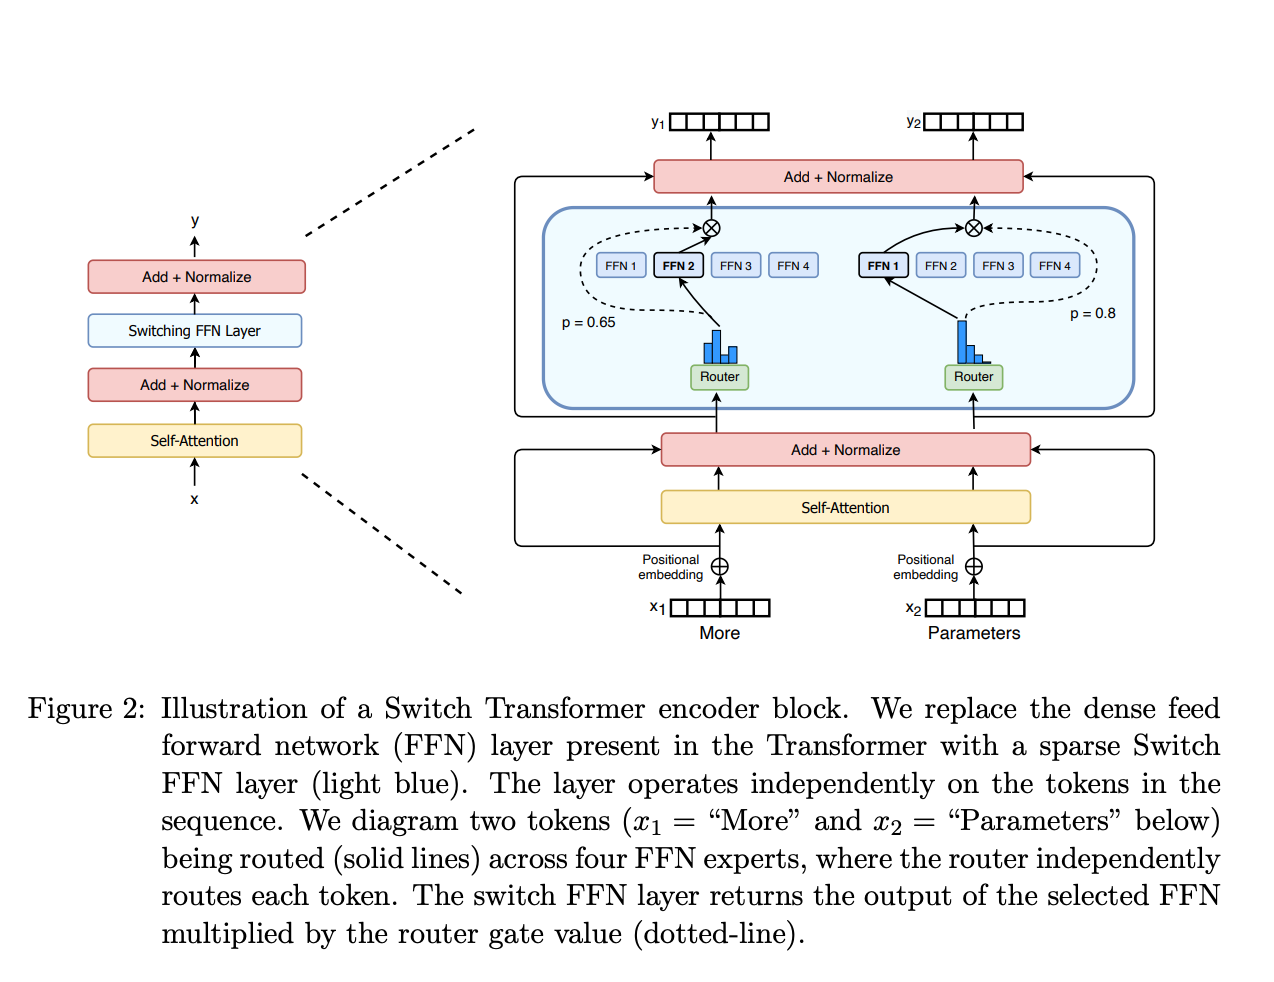

In [ ]:
class Sparse_MoE(nn.Module):
  def __init__(self, n_experts, topk_experts, expert_capacity, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.n_experts=n_experts
    self.topk_experts=topk_experts
    self.expert_capacity=expert_capacity
    self.gate=nn.Linear(input_dim, hidden_dim)
    self.experts=nn.ModuleList[Expert(input_dim, hidden_dim, output_dim) for _ in range(n_experts)]

  def forward(self, x):
    batch_size, input_dim=x.shape
    logits=self.gate(x)
    probs=F.softmax(logits, dim=-1)
    topk_probs, topk_indices= torch.topk(probs, self.topk_experts, dim=-1)

    #@ if training, load balancing is very necessary:
    if self.training:
      importance=probs.sum(dims=0)
      importance_loss=torch.var(importance)/(self.n_experts**2)
      mask=torch.zeros_like(probs, dtype=torch.bool)
      mask.scatter_(1, topk_indices, True)
      routing_probs=probs * mask
      expert_usage=mask.float().mean(0)
      routing_weights=routing_probs.mean(0)
      load_balance_loss=self.n_experts * (expert_usage * routing_weights).sum()
      aux_loss = importance_loss + load_balance_loss
